# Ανάλυση Εικόνας
## Υπολογιστική Εργασία 2022-2023



*   Χατζής Νικήτας Π19183
*   Δαρμής Αντώνης Π19040
*   Μουρλάς Παναγιώτης Π19108


## Περιεχόμενα



0.   Initial setup
1.   Preparing dataset
2.   Downloading and preparing pretrained model
3.   Algorithm implementation
4.   Extracting features and running the algorithm
5.   Visualizing results from the example
6.   Accuracy metrics





## 0. Initial Setup

Αρχικά κατεβάζουμε ένα helper function για να προβάλλουμε τις εικόνες.

In [ ]:
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py

--2023-01-09 17:19:05--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 416 Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



Στη συνέχεια κάνουμε install μια βιβλιοθήκη για υπεργραφήματα.

In [ ]:
!pip install hypernetx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Τέλος, κάνουμε import τα κατάλληλα libraries.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms,models
from torchvision.datasets import Caltech101
import matplotlib.pyplot as plt
import helper
import numpy as np
import random
import hypernetx as hnx

print("Setup complete")

Setup complete


## 1. Preparing the dataset

Αρχικά κατεβάζουμε το σύνολο των δεδομένων.

In [ ]:
data = Caltech101(root="./",download=True)

Files already downloaded and verified


Στο παρακάτω κελί ετοιμάζουμε κάποιους μετασχηματισμούς ώστε οι εικόνες μας να μπορούν να δοθούν ως είσοδο στο νευρωνικο δίκτυο.

In [ ]:
transforms = transforms.Compose([transforms.Resize(255),  #resize
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])  #cast to pytorch tensor type

Αποθηκεύουμε το μετασχηματισμένο σύνολο δεδομένων σε μια μεταβλητή.

In [ ]:
dataset = datasets.ImageFolder('/content/caltech101/101_ObjectCategories', transform=transforms)

Βλέπουμε το πλήθος εικόνων του dataset

In [ ]:
len(dataset)

9144

Επειδή ο αριθμός των εικόνων είναι μεγάλος κρατάμε μόνο ένα υποσύνολο από αυτές.

In [ ]:
dataset = list(dataset) #turn to list
random.shuffle(dataset)
keep_number = 2000

dataset = dataset[:keep_number]  #keep 2k images

Το σύνολο δεδομένων μας περιέχει εικόνες και το αντίστοιχο τους label, που είναι ένα σύνολο κατηγοριών/κλάσεων. Ξεχωρίζουμε τα labels από τις εικόνες αφού πρώτα ανακατέψουμε το dataset. 

In [ ]:
images,labels = map(list, zip(*dataset))  #separate images from labels

Το παραπάνω βήμα ήταν σημαντικό καθώς θα χρησιμοποιήσουμε τα labels αργότερα κατά την μέτρηση της ακρίβειας.
Στη συνέχεια προβάλλουμε την πρώτη εικόνα του ανακατεμμένου συνόλου.

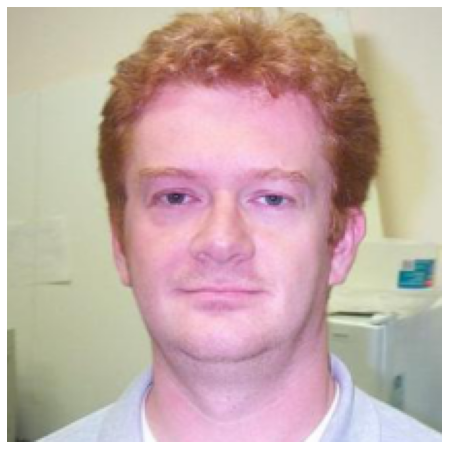

In [ ]:
helper.imshow(images[0],normalize=False)

## 2. Downloading and preparing a pretrained model.

Κατεβάζουμε ένα Vision Transformer με προεκπαιδευμένα βάρη που μας διαθέτει η pytorch, το βάζουμε στη GPU (αν υπάρχει) και παγώνουμε τα βάρη του για να μην αλλάξουν στις επόμενες εισόδους. Στο τέλος τυπώνουμε μια περιγραφή του δικτύου για να εξετάσουμε τη δομή του και να εντοπίσουμε το τελευταίο του επίπεδο

In [ ]:
model = models.vit_l_16(weights="DEFAULT")  #load pretrained network

device = "cuda" if torch.cuda.is_available() else "cpu" #set device as gpu if gpu is available

model.to(device)  #send model to chosen device

for param in model.parameters():  #freeze parameters
  param.requires_grad = False

print(model)  #print model summary

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

Βλέπουμε πως το τελευταίο επίπεδο είναι αυτό που βρίσκεται κάτω κάτω, οπότε το αντικαθιστούμε με ένα άδειο Sequential layer. Με τον τρόπο αυτό εξάγουμε τα χαρακτηρηστικά από το τελευταίο κρυφό επίπεδο. 

In [ ]:
model.heads.head = nn.Sequential() #replace final layer

Στη συνέχεια εξάγουμε τα χαρακτηριστικά από την τελευταία εικόνα για να δούμε τις διαστάσεις τους και να βεβαιωθούμε πως το προηγούμενο βήμα έγινε σωστά.

In [ ]:
img = images[0] #get an image

features_var = model(img.unsqueeze(0).to(device))  #extract features
features = features_var.data

In [ ]:
features.size()

torch.Size([1, 1024])

Βλέπουμε πως τα χαρακτηριστικά έχουν διαστάσεις 1x1024.

## 3. Algorithm Implementation
### Log-based Hypergraph of Ranking References (LHRR) 
Τώρα θα υλοποιήσουμε τις συναρτήσεις που αποτελούν τα βήματα του αλγορίθμου.

#### α) Initial similarity
Για την αρχικό similarity των εικόνων χρησιμοποιούμε το αντίστροφο της Ευκλέιδειας απόστασης των feature vectors των εικόνων.


In [ ]:
def similarity_lists(features):  #original similarity function
  '''
  Computes the euclidean distance between every pair of features.

  features = list of features extracted from each image
  '''
  T = [[(0,0) for i in range(len(features))] for j in range(len(features))]
  for i in range(len(features)):
    for j in range(i,len(features)):
      #since the distance is also computed between a feature vector and itself, we add a small value to avoid a devide by zero error
      score = 1/(np.linalg.norm(features[i].cpu()-features[j].cpu())+0.00001) #inverse euclidean distance
      #use the fact that euclidean distance is symmetrical to speed up computation (a-b)^2 = (b-a)^2

      T[i][j]=(score,j) #since these lists will be sorted later, we keep the image index together with the score
      T[j][i]=(score,i) #so that we know which score corresponds to each image/feature vector
  return T

#### β) Rank normalization

Ως τιμή του L χρησιμοποιούμε όλο των αριθμό των εικόνων/χαρακτηριστικών καθώς έχουμε ήδη διαλέξει ένα υποσύνολο από τις αρχικές ~9000 εικόνες.

In [ ]:
def rank_normalization(features,T): # rank normalization
  '''
  Performs reciprocal rank normalization as defined in the paper (page 4)
  ρ_n(i,j) = 2L - (τ_i(j)+τ_j(i)),
  for each list τ in T, then sorts τ.

  features = list of features extracted from each image
  T = list of lists of distances
  '''
  L = len(features)
  for i in range(len(T)): #compute score for each pair
    for j in range(i,len(T)):
      score = 2*L - (T[i][j][0] + T[j][i][0])
      T[i][j] = (score,j)
      T[j][i] = (score,i)
  T = [sorted(t,key = lambda x: x[0]) for t in T]  #sort each sublist
  return T

#### γ) Hyperedge construction

Για την κατασκευή των υπερακμών θεωρήσαμε (όπως προτάθηκε και στην τάξη), κάθε υπερακμή να είναι κεντραρισμένη σε μία εικόνα. Συνεπώς θα υπάρχουν όσες υπερακμές όσες και οι εικόνες μας (2000) και η κάθε υπερακμή θα περιέχει τις k εικόνες με το χαμηλότερο distance που προέκυψαν από το Rank Normalization. Σε κάθε περίπτωση ο πρώτος γείτονας στην υπερακμή i θα είναι η εικόνα i, οπότε τελικά η ένωση όλων των συνόλων των κόμβων των υπερακμών θα ισούται πάντα με το V.

In [ ]:
def make_hyperedges(T,k): #make e_i
  '''
  Creates hyperedges as lists of nodes.
  Hyperedge e_i contains the first k nodes of T[i].

  T = list of sorted similarities for each pair of image features
  k = size of neighborhood
  '''
  E = []  #empty list of hyperedges
  for t in T: #for each sublist
    temp = []
    for p in t[:k]: #for the top k pairs
      temp.append(p[1]) #get the second value (index) of the pair
    E.append(temp)
  return E  #return list of hyperedges

#### δ) Association/Incidence matrix

Κατασκευάζουμε τον πίνακα association χρησιμοποιώντας τη διαφοροποίηση που εξηγήθηκε στην τάξη. Το βάρος του ζευγαριού e_i-Vj εξαρτάται από το αν ο κόμβος/εικόνα Vj βρίσκεται στους πρώτους k γείτονες της εικόνας Vi (δηλαδή τους κόμβους της υπερακμής e_i). Ο πρώτος από τους γείτονες (που είναι η ίδια η εικόνα) έχει βάρος 1 (log0) άρα η διαγώνιος αποτελείται από 1. Έπειτα τα βάρη μειώνονται σταδιακά. Αν δεν βρίσκεται στους πρώτους κ γείτονες έχει τιμή 0. 

In [ ]:
def association(E,V,T,k):
  '''
  Creates the association/incidence matrix r(e_i,v_j)=h(e_i,v_j).
  Based on pages 4,5 of the paper and info given in the class.

  Note: In our variation, since each hyperedge is centered around a node/image, it is clear that |E| = |V|. 
  Thus, the second parameter V can also be the list of hyperedges, since we only use its length. 

  E = list of hyperedges (each hyperedge is a list of nodes)
  V = list of nodes in the hypergraph
  T = list of sorted similarities for each pair of image features
  k = neighborhood size
  '''
  R = np.zeros((len(E),len(E)))
  for i,e in enumerate(E):  #for each edge
    for v in range(len(V)): #for each vertex
      if v in e:  #if vertex is in the hyperedge
        pos = e.index(v)+1  #get the position (+1 because counting in the paper starts from 1)
        R[i][v] = 1-np.math.log(pos,k+1)  #compute the weight
      else: #if vertex is not in the hyperedge
        R[i][v] = 0 #weight is 0
  return R

#### ε) Hypergraph construction

Εδώ κατασκευάζαμε το υπεργράφημα από τη λίστα των υπερακμών. Τελικά ωστόσο δεν χρειάστηκε το υπεργράφημα (εξήγηση υπάρχει στο σχόλιο Note: στο παραπάνω κελί) και επίσης δεν καταφέραμε ούτε να το οπτικοποιήσουμε (η draw function έβγαζε exception) οπότε η παρακάτω συνάρτηση δεν χρησιμοποιείται πουθενά.

In [ ]:
def make_hypergraph(E):
  '''
  Creates a hypergraph object using the HyperNetX library.

  E = list of hyperedges
  '''
  ed = {} #edge dictionary
  for i,e in enumerate(E):
    label = "e"+str(i)
    ed[label] = e
  HG = hnx.Hypergraph(ed)
  return HG

#### στ) Hyperedge weights
Εδώ υπολογίζουμε τα βάρη των υπερακμών με βάση των τύπο στο paper.

In [ ]:
def edge_weights(E,assoc):
  '''
  Computes edge weights as defined in page 6 of the paper.

  E = list of hyperedges
  assoc = association/incidence matrix H
  '''
  w = []
  for i,e in enumerate(E):  #for each hyperedge
    s=0
    for j in e: #for each node in the hyperedge
      s+= assoc[i][j]
    w.append(s)
  return w

#### ι) Hyperedge similarities

Εδώ υπολογίζουμε το pairwise similarity matrix με βάση τον τύπο στο paper.

In [ ]:
def hyperedge_similarities(assoc):  #Hyperedge Similarities
  '''
  Computes pairwise similarity matrix S as defined in page 6 of the paper.
  '''
  H = np.array(assoc)
  Sh = H @ H.T  # @ = matrix multiplication
  Su = H.T @ H
  S = np.multiply(Sh,Su)  # Hadamard product
  return S


#### ια) Membership degrees
Εδώ υπολογίζουμε τα membership degrees όπως και το paper. Αρχικά ορίζουμε και μια βοηθητική συνάρτηση που κατασκευάζει το καρτεσιανό γινόμενο μεταξύ 2 υπερακμών.

In [ ]:
def cartesian_product(eq,ei):
  '''
  Creates the cartesian product of 2 hyperedges (lists of nodes)

  eq, ei = hyperedges
  '''
  return np.transpose([np.tile(eq, len(ei)), np.repeat(eq, len(ei))])

def pairwise_similarity_relationship(w,assoc,E):
  '''
  Computes pairwise similarity relationship / membership degrees as defined in page 6 of the paper.

  w = hyperedge weights
  assoc = incidence/association matrix
  E = list of hyperedges
  '''

  # v_i, v_j in e_q^2 (cartesian product)
  #p(e_q,v_i,v_j) = |E| x |e_q^2| 
  
  p = [{} for _ in range(len(E))] #for each hyperedge create a dictionary with node pairs as keys
  for i,e in enumerate(E):
    cp3 = cartesian_product(e,e)
    for (v1,v2) in cp3:
      p[i][(v1,v2)] = w[i]*assoc[i][v1]*assoc[i][v2]
  return p

#### ιβ) Similarity based on the cartesian product.
Εδώ κατασκευάζουμε τον πίνακα c του paper (σελίδα 6).

In [ ]:
def make_C(E,p):
  '''
  Computes the similarity based on the cartesian product (page 6).

  E = list of hyperedges
  p = list of membership degrees for each pair in each hyperedge
  '''
  C = np.zeros((len(E),len(E)))
  for i,e in enumerate(E):  #for each hyperedge
    for (v1,v2) in p[i]:  #for each pair in the dict
      C[v1][v2]+=p[i][(v1,v2)]  #compute value
  return C

#### ιγ) Affinity matrix
Τέλος κατασκευάζουμε τον τελικό πίνακα W.

In [ ]:
def affinity_matrix(C,S):
  '''
  Computes final affinity matrix (page 6)
  '''
  return np.multiply(C,S)

#### ALL TOGETHER
Στο παρακάτω κελί ενώνουμε όλα τα επιμέρους βήματα του αλγορίθμου σε μία συνάρτηση.

In [ ]:
def LHRR(features,init_lists,k=3,num_iters=10):
  '''
  Entire LHRR algorithm put together

  features = list of features extracted from each image
  init_lists = initial similarity lists based on euclidean distance
  k = neighborhood size / hyperedge size
  num_iters = for how many iterations the algorithm will run
  '''

  for i in range(num_iters):

    T = rank_normalization(features,init_lists)  #perform rank normalization

    E = make_hyperedges(T,k)  #make hyperedges

    #HG = make_hypergraph(E)  #make hypergraph

    assoc = association(E,E,T,k)  #make association/incidence matrix 
    #There is an explanation above as to why E is passed two times

    w = edge_weights(E,assoc) #compute edge weights

    S = hyperedge_similarities(assoc) #compute hyper-edge similarities

    p = pairwise_similarity_relationship(w,assoc,E) #compute pairwise relationships

    C = make_C(E,p) #make the cartesian product based similarity matrix

    aff = affinity_matrix(C,S)  #compute the final matrix W

    # reshape final matrix so it becomes input of the next iteration
    aff = aff.tolist()

    for i,row in enumerate(aff):
      for j,v in enumerate(row):
        aff[i][j] = (aff[i][j],j) #add information about the index

    T = aff
  return aff

## 4. Extracting features and running the algorithm.

Αρχικά χρησιμοποιούμε το νευρωνικό για την εξαγωγή των χαρακτηρστικών.

In [ ]:
features = []

for img in images:
  features.append(model(img.unsqueeze(0).to(device))) #~1.5m for 2000 images with gpu


print(len(features))

2000


In [ ]:
#backup = features[:]

Στη συνέχεια τρέχουμε τον αλγόριθμο για 3 επαναλήψεις. Να σημειωθεί πως το αλγόριθμος παίρνει λίγη ώρα ~5-10 λεπτά καθώς δεν θεωρούμε συγκεκριμένες εικόνες ως query images, αλλά υπολογίζουμε τα σκορ για όλες τις εικόνες (2000). Η μεγάλη καθυστέρηση προκύπτει αρχικά όταν υπολογίζονται ευκλείδιες αποστάσεις για 2000*2000 feature vectors (όλα μεταξύ τους). Ωστόσο στο επόμενο βήμα μπορούμε να χρησιμοποιήσουμε οποιαδήποτε από τις 2000 εικόνες θέλουμε ως query image.

Τις αρχικές λίστες με τις αντίστροφες Ευκλείδιες αποστάσεις τις υπολογίζουμε εκτός του αλγορίθμου.

In [ ]:
init_lists = similarity_lists(features)

Έπειτα τρέχουμε τον αλγόριθμο.

In [ ]:
final_ranking = LHRR(features,init_lists,k=3,num_iters=3)  #final matrix W

## 5. Visualizing results from the example.

Εδώ εμφανίζουμε τα αποτελέσματα για την πρώτη εικόνα. Περισσότερα παραδείγματα υπάρχουν στο pdf.

In [ ]:
query_index = 0 #first image
retrieved = []  #keep indexes and scores of relevant images here
for (score,i) in final_ranking[query_index]:  #search first row of W
  if score!=0:  #if score is non zero
    retrieved.append((score,i))
retrieved = sorted(retrieved,key = lambda x: x[0],reverse=True) #sort by score

print(retrieved)

[(3.691692975197335, 0), (0.6047548240938942, 1876), (0.21343984370492775, 436), (0.015259401746890366, 1278)]


In [ ]:
for (score,i) in retrieved[1:]:
  print(score,i)

0.6047548240938942 1876
0.21343984370492775 436
0.015259401746890366 1278


Στην παραπάνω λίστα φαινόνται τα ζευγάρια (retrieved image score, retrieved image index). Προφανώς για την εικόνα 0 μεγαλύτερο σκορ έχει η ίδια η εικόνα 0. Στη συνέχεια προβάλουμε τις εικόνες με τη σειρά.

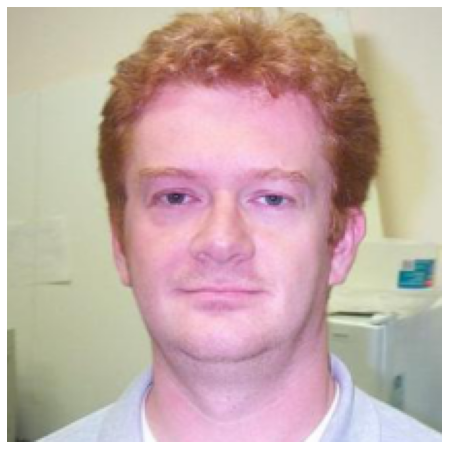

In [ ]:
helper.imshow(images[0],normalize=False)

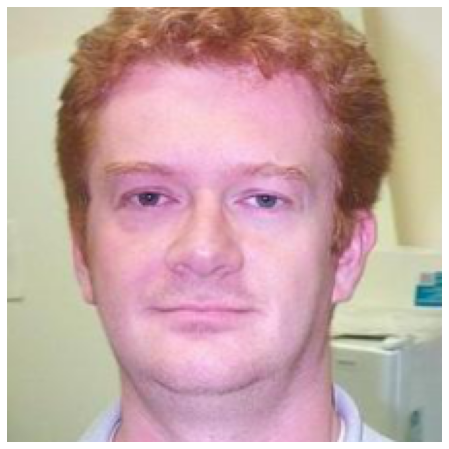

In [ ]:
helper.imshow(images[1876],normalize=False)

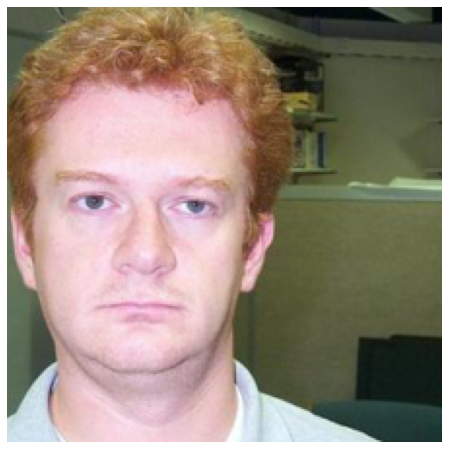

In [ ]:
helper.imshow(images[436],normalize=False)

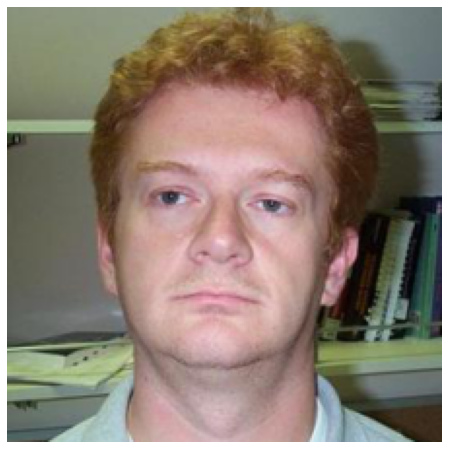

In [ ]:
helper.imshow(images[1278],normalize=False)

Όπως φαίνεται, όλες οι εικόνες είναι εικόνες προσώπων (και μάλιστα του ίδου ανθρώπου) οπότε είναι relevant. Περισσότερα παραδείγματα εκτέλεσης στο pdf.

## 6. Accuracy metrics

Εδώ χρησιμοποιούμε precision και recall για να εκτιμήσουμε την ακρίβεια του αλγορίθμου. Δύο εικόνες θεωρούνται relevant/similar αν έχουν το ίδιο label. Υπολογίζουμε precision και recall για την εικόνα 0 (περισσότερα παραδείγματα στο pdf). 

In [ ]:
def precision(query_index,final_ranking,labels,k=5):
  '''
  Compute precision using labels.

  index = index of query image
  final_ranking = affinity matrix W with final results
  labels = image labels
  k = number of retrieved images to keep
  '''

  retrieved = []
  for (score,i) in final_ranking[query_index]:
    if score!=0:  #get all non zero scores
      retrieved.append((score,i))
  retrieved = sorted(retrieved,key = lambda x: x[0],reverse=True) #sort based on scores

  retrieved = retrieved[1:k+1] #keep first k excluding the image itself which is always first

  true_label = labels[query_index]  #get target label
  c=0 #keep a counter
  for score,ix in retrieved:
    if labels[ix]==true_label:
      c+=1  #increment counter on correct label
  
  return c/len(retrieved) #return pct of correct labels

In [ ]:
q_img = 0
p = precision(q_img,final_ranking,labels)
print("Precision for image "+str(q_img)+" is:",p)

Precision for image 0 is: 0.6666666666666666


Το precision βγαίνει 66% παρόλο που και οι 3 εικόνες είναι εικόνες προσώπων. Αυτό συμβαίνει επειδή υπάρχουν 2 ήδη labels για πρόσωπα: "faces" και "faces_easy" με ids 1 και 2 αντίστοιχα. Αν τυπώσουμε τα labels βλέπουμε πως 1 από τις 3 retrieved εικόνες έχει label=2 ενώ η query εικόνα και οι άλλες 2 retrieved έχουν label=1. Άρα P= 2/3 = 0.66

In [ ]:
print("Query label: ",labels[0])

Query label:  1


In [ ]:
print("Retrieved image #1 label: ",labels[1876])

Retrieved image #1 label:  2


In [ ]:
print("Retrieved image #2 label: ",labels[436])

Retrieved image #2 label:  1


In [ ]:
print("Retrieved image #3 label: ",labels[1278])

Retrieved image #3 label:  1


Όσον αφορά τα ονόματα των labels στα οποία αντιστοιχούν τα παραπάνω ids, μπορούμε να κοιτάξουμε στο filestructure του dataset.
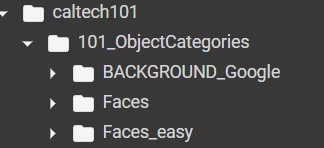

Ξεκινώντας την αρίθμηση από το 0 βλέπουμε πως οι κλάσεις "faces","faces_easy" έχουν ids 1,2 αντίστοιχα (υπάρχουν άλλες 98 κλάσεις αλλά δεν φαίνονται στην cropped εικόνα).
Περισσότερα παραδείγματα precision υπάρχουν στο pdf.

Στη συνέχεια κατασκευάζουμε το recall. Εξήγηση για τα αποτελέσματα, καθώς και περισσότερα παραδείγματα υπάρχουν στο pdf.

In [ ]:
def recall(query_index,final_ranking,labels):
  ixs = []
  for (score,i) in final_ranking[query_index]:  #get indexes of all retrieved images
    if score!=0:
      ixs.append(i)
  ixs = sorted(ixs,reverse=True)

  true_label = labels[query_index]
  c=0 #count correctly retrieved images
  for ix in ixs[1:]:
    if labels[ix]==true_label:
      c+=1

  db_c = 0  #count all images with same label as query image
  for l in labels:
    if l==true_label:
      db_c += 1
  
  return c/(db_c-1)

In [ ]:
q_img = 0
r = recall(q_img,final_ranking,labels)
print("Recall for image "+str(q_img)+" is:",r)

Recall for image 0 is: 0.0069124423963133645


Περισσότερα παραδείγματα υπάρχουν στο pdf.